In [1]:
# ============================================================
# NIFTY OPTIONS TRADING SYSTEM (DAILY – NSE READY)
# ============================================================

# ------------------ LIBRARIES ------------------
!pip install yfinance scipy ta -q

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from ta.momentum import RSIIndicator
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1. DATA DOWNLOAD (DECEMBER – DAILY)
# ============================================================

start = "2024-01-01"
end   = "2024-12-31"

nifty = yf.download("^NSEI", start=start, end=end)
vix   = yf.download("^INDIAVIX", start=start, end=end)

data = pd.concat([nifty['Close'], vix['Close']], axis=1)
data.columns = ['NIFTY', 'INDIA_VIX']
data.dropna(inplace=True)

# ============================================================
# 2. VOLATILITY REGIME IDENTIFICATION (STEP 1)
# ============================================================

data['VIX_Change'] = data['INDIA_VIX'].diff()
data['VIX_RSI'] = RSIIndicator(data['INDIA_VIX'], window=14).rsi()

def classify_vix_regime(vix, change):
    if vix < 15:
        return "LOW_VOL"
    elif 15 <= vix <= 20 and change > 0:
        return "RISING_VOL"
    elif vix > 20:
        return "HIGH_VOL"
    else:
        return "NEUTRAL"

data['Vol_Regime'] = data.apply(
    lambda x: classify_vix_regime(x['INDIA_VIX'], x['VIX_Change']),
    axis=1
)

# ============================================================
# 3. STRATEGY SELECTION (STEP 2)
# ============================================================

def select_strategy(regime):
    if regime == "LOW_VOL":
        return "SHORT_STRANGLE"
    elif regime == "RISING_VOL":
        return "LONG_STRADDLE"
    elif regime == "HIGH_VOL":
        return "HEDGE_ONLY"
    else:
        return "NO_TRADE"

data['Strategy'] = data['Vol_Regime'].apply(select_strategy)

# ============================================================
# 4. OPTION PRICING (BLACK–SCHOLES)
# ============================================================

def bs_price(S, K, T, r, sigma, opt):
    if T <= 0:
        return max(S-K,0) if opt=="CALL" else max(K-S,0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if opt=="CALL":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ============================================================
# 5. STRIKE SELECTION & WEEKLY EXPIRY (STEP 3)
# ============================================================

def select_strikes(spot):
    atm = round(spot/50)*50
    return atm, atm+100, atm-100, atm+300, atm-300

def days_to_expiry(date):
    return max(4 - date.weekday(), 0)

data['Days_To_Expiry'] = data.index.map(days_to_expiry)
data['T'] = data['Days_To_Expiry'] / 252

# ============================================================
# 6. STRATEGY EXECUTION (PREMIUMS + HEDGES)
# ============================================================

RISK_FREE = 0.06
TCOST = 0.0015  # 0.15%

pnl_list = []

for i in range(len(data)):
    row = data.iloc[i]
    S = row['NIFTY']
    sigma = row['INDIA_VIX']/100
    T = max(row['T'], 1/252)

    atm, call, put, hcall, hput = select_strikes(S)
    pnl = 0

    # -------- SHORT STRANGLE (HEDGED) --------
    if row['Strategy'] == "SHORT_STRANGLE":
        premium = (
            bs_price(S, call, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, put,  T, RISK_FREE, sigma, "PUT")
        )
        hedge = (
            bs_price(S, hcall, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, hput,  T, RISK_FREE, sigma, "PUT")
        )
        pnl = premium - hedge

    # -------- LONG STRADDLE --------
    elif row['Strategy'] == "LONG_STRADDLE":
        pnl = -(
            bs_price(S, atm, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, atm, T, RISK_FREE, sigma, "PUT")
        )

    # -------- HIGH VOL / NO TRADE --------
    else:
        pnl = 0

    pnl = pnl * (1 - TCOST)
    pnl_list.append(pnl)

data['Daily_PnL'] = pnl_list

# ============================================================
# 7. POSITION SIZING & PORTFOLIO RETURNS (STEP 4)
# ============================================================

CAPITAL = 1_000_00000      # ₹10 lakh
RISK_PCT = 0.01          # 1% risk
MAX_LOSS_PER_LOT = 10_000

lots = int((CAPITAL*RISK_PCT)//MAX_LOSS_PER_LOT)

data['Portfolio_Return'] = (data['Daily_PnL'] * lots) / CAPITAL

# ============================================================
# 8. RISK METRICS: VaR & ES
# ============================================================

def historical_var(returns, conf=0.95):
    return np.percentile(returns, (1-conf)*100)

def expected_shortfall(returns, conf=0.95):
    var = historical_var(returns, conf)
    return returns[returns <= var].mean()

VaR_95 = historical_var(data['Portfolio_Return'], 0.95)
ES_95  = expected_shortfall(data['Portfolio_Return'], 0.95)

# ============================================================
# 9. PERFORMANCE SUMMARY
# ============================================================

equity = (1 + data['Portfolio_Return']).cumprod()
max_dd = (equity / equity.cummax() - 1).min()
sharpe = (
    data['Portfolio_Return'].mean() /
    data['Portfolio_Return'].std()
) * np.sqrt(252)

print("\n========= FINAL PERFORMANCE SUMMARY =========")
print("Total Return :", round(equity.iloc[-1]-1, 4))
print("Sharpe Ratio :", round(sharpe, 2))
print("Max Drawdown :", round(max_dd, 4))
print("VaR (95%)    :", round(VaR_95, 4))
print("ES (95%)     :", round(ES_95, 4))
print("Lots Traded  :", lots)


  Preparing metadata (setup.py) ... done


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



========= FINAL PERFORMANCE SUMMARY =========
Total Return : 0.0062
Sharpe Ratio : 3.02
Max Drawdown : -0.0028
VaR (95%)    : -0.0003
ES (95%)     : -0.0004
Lots Traded  : 100


In [2]:
# ============================================================
# NIFTY OPTIONS TRADING SYSTEM (DAILY – NSE READY)
# FULL YEAR 2024 | TRADE-BY-TRADE SUMMARY
# ============================================================

# ------------------ LIBRARIES ------------------
!pip install yfinance scipy ta -q

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from ta.momentum import RSIIndicator
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1. DATA DOWNLOAD (FULL YEAR 2024)
# ============================================================

start = "2024-01-01"
end   = "2024-12-31"

nifty = yf.download("^NSEI", start=start, end=end)
vix   = yf.download("^INDIAVIX", start=start, end=end)

data = pd.concat([nifty['Close'], vix['Close']], axis=1)
data.columns = ['NIFTY', 'INDIA_VIX']
data.dropna(inplace=True)

# ============================================================
# 2. VOLATILITY REGIME IDENTIFICATION (STEP 1)
# ============================================================

data['VIX_Change'] = data['INDIA_VIX'].diff()
data['VIX_RSI'] = RSIIndicator(data['INDIA_VIX'], window=14).rsi()

def classify_vix_regime(vix, change):
    if vix < 15:
        return "LOW_VOL"
    elif 15 <= vix <= 20 and change > 0:
        return "RISING_VOL"
    elif vix > 20:
        return "HIGH_VOL"
    else:
        return "NEUTRAL"

data['Vol_Regime'] = data.apply(
    lambda x: classify_vix_regime(x['INDIA_VIX'], x['VIX_Change']),
    axis=1
)

# ============================================================
# 3. STRATEGY SELECTION (STEP 2)
# ============================================================

def select_strategy(regime):
    if regime == "LOW_VOL":
        return "SHORT_STRANGLE"
    elif regime == "RISING_VOL":
        return "LONG_STRADDLE"
    elif regime == "HIGH_VOL":
        return "HEDGE_ONLY"
    else:
        return "NO_TRADE"

data['Strategy'] = data['Vol_Regime'].apply(select_strategy)

# ============================================================
# 4. BLACK–SCHOLES OPTION PRICING
# ============================================================

def bs_price(S, K, T, r, sigma, opt):
    if T <= 0:
        return max(S-K,0) if opt=="CALL" else max(K-S,0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if opt=="CALL":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ============================================================
# 5. STRIKES & WEEKLY EXPIRY (STEP 3)
# ============================================================

def select_strikes(spot):
    atm = round(spot/50)*50
    return atm, atm+100, atm-100, atm+300, atm-300

def days_to_expiry(date):
    return max(4 - date.weekday(), 0)

data['Days_To_Expiry'] = data.index.map(days_to_expiry)
data['T'] = data['Days_To_Expiry'] / 252

# ============================================================
# 6. STRATEGY EXECUTION + TRADE LOG
# ============================================================

RISK_FREE = 0.06
TCOST = 0.0015  # 0.15%

trade_log = []

for i in range(len(data)):
    row = data.iloc[i]
    date = data.index[i]

    S = row['NIFTY']
    sigma = row['INDIA_VIX'] / 100
    T = max(row['T'], 1/252)

    atm, call, put, hcall, hput = select_strikes(S)

    premium = 0
    hedge = 0
    pnl = 0

    # ---- SHORT STRANGLE (HEDGED) ----
    if row['Strategy'] == "SHORT_STRANGLE":
        premium = (
            bs_price(S, call, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, put,  T, RISK_FREE, sigma, "PUT")
        )
        hedge = (
            bs_price(S, hcall, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, hput,  T, RISK_FREE, sigma, "PUT")
        )
        pnl = premium - hedge

    # ---- LONG STRADDLE ----
    elif row['Strategy'] == "LONG_STRADDLE":
        premium = (
            bs_price(S, atm, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, atm, T, RISK_FREE, sigma, "PUT")
        )
        pnl = -premium

    pnl = pnl * (1 - TCOST)

    trade_log.append({
        "Date": date,
        "NIFTY": S,
        "India_VIX": row['INDIA_VIX'],
        "Vol_Regime": row['Vol_Regime'],
        "Strategy": row['Strategy'],
        "ATM_Strike": atm,
        "OTM_Call": call,
        "OTM_Put": put,
        "Premium": round(premium,2),
        "Hedge_Cost": round(hedge,2),
        "Net_Daily_PnL": round(pnl,2)
    })

trades = pd.DataFrame(trade_log)

# ============================================================
# 7. POSITION SIZING & PORTFOLIO RETURNS (STEP 4)
# ============================================================

CAPITAL = 10_000_000     # ₹1 crore
RISK_PCT = 0.01
MAX_LOSS_PER_LOT = 10_000

lots = max(1, int((CAPITAL * RISK_PCT) // MAX_LOSS_PER_LOT))

trades['Portfolio_Return'] = (trades['Net_Daily_PnL'] * lots) / CAPITAL
trades['Cumulative_Equity'] = (1 + trades['Portfolio_Return']).cumprod()

# ============================================================
# 8. RISK METRICS: VaR & ES
# ============================================================

def historical_var(returns, conf=0.95):
    return np.percentile(returns, (1-conf)*100)

def expected_shortfall(returns, conf=0.95):
    var = historical_var(returns, conf)
    return returns[returns <= var].mean()

VaR_95 = historical_var(trades['Portfolio_Return'], 0.95)
ES_95  = expected_shortfall(trades['Portfolio_Return'], 0.95)

# ============================================================
# 9. FINAL PERFORMANCE SUMMARY
# ============================================================

equity = trades['Cumulative_Equity']
max_dd = (equity / equity.cummax() - 1).min()
sharpe = (
    trades['Portfolio_Return'].mean() /
    trades['Portfolio_Return'].std()
) * np.sqrt(252)

print("\n========= FINAL PERFORMANCE SUMMARY =========")
print("Total Return :", round(equity.iloc[-1]-1, 4))
print("Sharpe Ratio :", round(sharpe, 2))
print("Max Drawdown :", round(max_dd, 4))
print("VaR (95%)    :", round(VaR_95, 4))
print("ES (95%)     :", round(ES_95, 4))
print("Lots Traded  :", lots)

# ============================================================
# 10. TRADE-BY-TRADE SUMMARY (OUTPUT)
# ============================================================

executed_trades = trades[
    trades['Strategy'].isin(["SHORT_STRANGLE", "LONG_STRADDLE"])
]

print("\n========= TRADE-BY-TRADE SUMMARY =========")
print(executed_trades.head(10))

# Optional export
executed_trades.to_excel("NIFTY_Options_Trades_2024.xlsx", index=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



========= FINAL PERFORMANCE SUMMARY =========
Total Return : 0.0062
Sharpe Ratio : 3.02
Max Drawdown : -0.0028
VaR (95%)    : -0.0003
ES (95%)     : -0.0004
Lots Traded  : 10

========= TRADE-BY-TRADE SUMMARY =========
        Date         NIFTY  India_VIX Vol_Regime        Strategy  ATM_Strike  \
0 2024-01-02  21665.800781      14.58    LOW_VOL  SHORT_STRANGLE       21650   
1 2024-01-03  21517.349609      14.10    LOW_VOL  SHORT_STRANGLE       21500   
2 2024-01-04  21658.599609      13.33    LOW_VOL  SHORT_STRANGLE       21650   
3 2024-01-05  21710.800781      12.63    LOW_VOL  SHORT_STRANGLE       21700   
4 2024-01-08  21513.000000      13.46    LOW_VOL  SHORT_STRANGLE       21500   
5 2024-01-09  21544.849609      13.26    LOW_VOL  SHORT_STRANGLE       21550   
6 2024-01-10  21618.699219      12.97    LOW_VOL  SHORT_STRANGLE       21600   
7 2024-01-11  21647.199219      12.77    LOW_VOL  SHORT_STRANGLE       21650   
8 2024-01-12  21894.550781      13.10    LOW_VOL  SHORT_STRA

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



========= FINAL PERFORMANCE SUMMARY =========
Total Return : 0.0062
Sharpe Ratio : 3.02
Max Drawdown : -0.0028
VaR (95%)    : -0.0003
ES (95%)     : -0.0004
Lots Traded  : 10


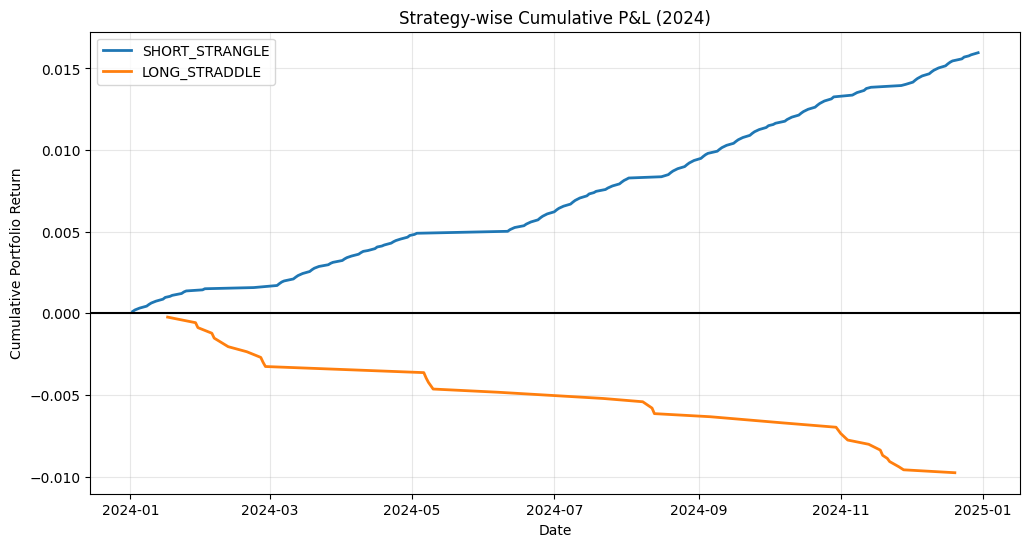

<Figure size 800x500 with 0 Axes>

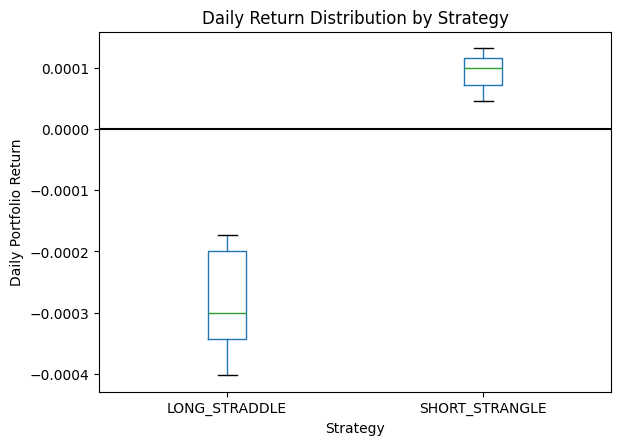

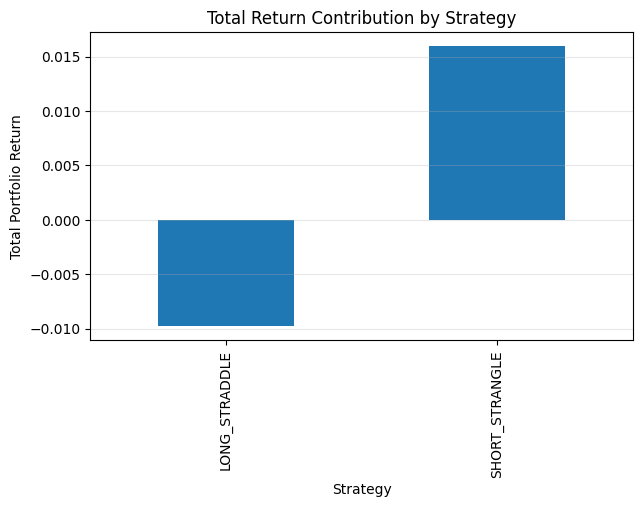

In [3]:
# ============================================================
# NIFTY OPTIONS TRADING SYSTEM (DAILY – NSE READY)
# FULL YEAR 2024 | TRADE LOG + STRATEGY P&L CHARTS
# ============================================================

# ------------------ LIBRARIES ------------------
!pip install yfinance scipy ta -q

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from ta.momentum import RSIIndicator
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1. DATA DOWNLOAD (FULL YEAR 2024)
# ============================================================

start = "2024-01-01"
end   = "2024-12-31"

nifty = yf.download("^NSEI", start=start, end=end)
vix   = yf.download("^INDIAVIX", start=start, end=end)

data = pd.concat([nifty['Close'], vix['Close']], axis=1)
data.columns = ['NIFTY', 'INDIA_VIX']
data.dropna(inplace=True)

# ============================================================
# 2. VOLATILITY REGIME IDENTIFICATION
# ============================================================

data['VIX_Change'] = data['INDIA_VIX'].diff()
data['VIX_RSI'] = RSIIndicator(data['INDIA_VIX'], window=14).rsi()

def classify_vix_regime(vix, change):
    if vix < 15:
        return "LOW_VOL"
    elif 15 <= vix <= 20 and change > 0:
        return "RISING_VOL"
    elif vix > 20:
        return "HIGH_VOL"
    else:
        return "NEUTRAL"

data['Vol_Regime'] = data.apply(
    lambda x: classify_vix_regime(x['INDIA_VIX'], x['VIX_Change']),
    axis=1
)

# ============================================================
# 3. STRATEGY SELECTION
# ============================================================

def select_strategy(regime):
    if regime == "LOW_VOL":
        return "SHORT_STRANGLE"
    elif regime == "RISING_VOL":
        return "LONG_STRADDLE"
    elif regime == "HIGH_VOL":
        return "HEDGE_ONLY"
    else:
        return "NO_TRADE"

data['Strategy'] = data['Vol_Regime'].apply(select_strategy)

# ============================================================
# 4. BLACK–SCHOLES OPTION PRICING
# ============================================================

def bs_price(S, K, T, r, sigma, opt):
    if T <= 0:
        return max(S-K,0) if opt=="CALL" else max(K-S,0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if opt=="CALL":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ============================================================
# 5. STRIKE SELECTION & WEEKLY EXPIRY
# ============================================================

def select_strikes(spot):
    atm = round(spot/50)*50
    return atm, atm+100, atm-100, atm+300, atm-300

def days_to_expiry(date):
    return max(4 - date.weekday(), 0)

data['Days_To_Expiry'] = data.index.map(days_to_expiry)
data['T'] = data['Days_To_Expiry'] / 252

# ============================================================
# 6. STRATEGY EXECUTION + TRADE LOG
# ============================================================

RISK_FREE = 0.06
TCOST = 0.0015  # 0.15%

trade_log = []

for i in range(len(data)):
    row = data.iloc[i]
    date = data.index[i]

    S = row['NIFTY']
    sigma = row['INDIA_VIX'] / 100
    T = max(row['T'], 1/252)

    atm, call, put, hcall, hput = select_strikes(S)

    premium = 0
    hedge = 0
    pnl = 0

    if row['Strategy'] == "SHORT_STRANGLE":
        premium = (
            bs_price(S, call, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, put,  T, RISK_FREE, sigma, "PUT")
        )
        hedge = (
            bs_price(S, hcall, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, hput,  T, RISK_FREE, sigma, "PUT")
        )
        pnl = premium - hedge

    elif row['Strategy'] == "LONG_STRADDLE":
        premium = (
            bs_price(S, atm, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, atm, T, RISK_FREE, sigma, "PUT")
        )
        pnl = -premium

    pnl = pnl * (1 - TCOST)

    trade_log.append({
        "Date": date,
        "Strategy": row['Strategy'],
        "Vol_Regime": row['Vol_Regime'],
        "Net_PnL": pnl
    })

trades = pd.DataFrame(trade_log)

# ============================================================
# 7. POSITION SIZING & PORTFOLIO RETURNS
# ============================================================

CAPITAL = 10_000_000     # ₹1 crore
RISK_PCT = 0.01
MAX_LOSS_PER_LOT = 10_000

lots = max(1, int((CAPITAL * RISK_PCT) // MAX_LOSS_PER_LOT))

trades['Portfolio_Return'] = (trades['Net_PnL'] * lots) / CAPITAL
trades['Equity'] = (1 + trades['Portfolio_Return']).cumprod()

# ============================================================
# 8. RISK METRICS
# ============================================================

def historical_var(returns, conf=0.95):
    return np.percentile(returns, (1-conf)*100)

def expected_shortfall(returns, conf=0.95):
    var = historical_var(returns, conf)
    return returns[returns <= var].mean()

VaR_95 = historical_var(trades['Portfolio_Return'], 0.95)
ES_95  = expected_shortfall(trades['Portfolio_Return'], 0.95)

# ============================================================
# 9. FINAL PERFORMANCE SUMMARY
# ============================================================

equity = trades['Equity']
max_dd = (equity / equity.cummax() - 1).min()
sharpe = (
    trades['Portfolio_Return'].mean() /
    trades['Portfolio_Return'].std()
) * np.sqrt(252)

print("\n========= FINAL PERFORMANCE SUMMARY =========")
print("Total Return :", round(equity.iloc[-1]-1, 4))
print("Sharpe Ratio :", round(sharpe, 2))
print("Max Drawdown :", round(max_dd, 4))
print("VaR (95%)    :", round(VaR_95, 4))
print("ES (95%)     :", round(ES_95, 4))
print("Lots Traded  :", lots)

# ============================================================
# 10. STRATEGY-WISE P&L CHARTS
# ============================================================

strategy_trades = trades[
    trades['Strategy'].isin(["SHORT_STRANGLE", "LONG_STRADDLE"])
].copy()

strategy_trades['Strategy_Cum_PnL'] = (
    strategy_trades.groupby('Strategy')['Portfolio_Return'].cumsum()
)

# --- Cumulative P&L by Strategy ---
plt.figure(figsize=(12,6))
for strat in strategy_trades['Strategy'].unique():
    subset = strategy_trades[strategy_trades['Strategy'] == strat]
    plt.plot(subset['Date'], subset['Strategy_Cum_PnL'], label=strat, linewidth=2)

plt.axhline(0, color='black')
plt.title("Strategy-wise Cumulative P&L (2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Portfolio Return")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Daily Return Distribution ---
plt.figure(figsize=(8,5))
strategy_trades.boxplot(column='Portfolio_Return', by='Strategy', grid=False)
plt.title("Daily Return Distribution by Strategy")
plt.suptitle("")
plt.axhline(0, color='black')
plt.ylabel("Daily Portfolio Return")
plt.show()

# --- Total Contribution ---
strategy_trades.groupby('Strategy')['Portfolio_Return'].sum().plot(
    kind='bar', figsize=(7,4), title="Total Return Contribution by Strategy"
)
plt.ylabel("Total Portfolio Return")
plt.grid(axis='y', alpha=0.3)
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



========= FINAL PERFORMANCE SUMMARY =========
Total Return : 0.0017
Sharpe Ratio : 49.75
Max Drawdown : 0.0
VaR (95%)    : 0.0
ES (95%)     : 0.0
Lots Traded  : 1000


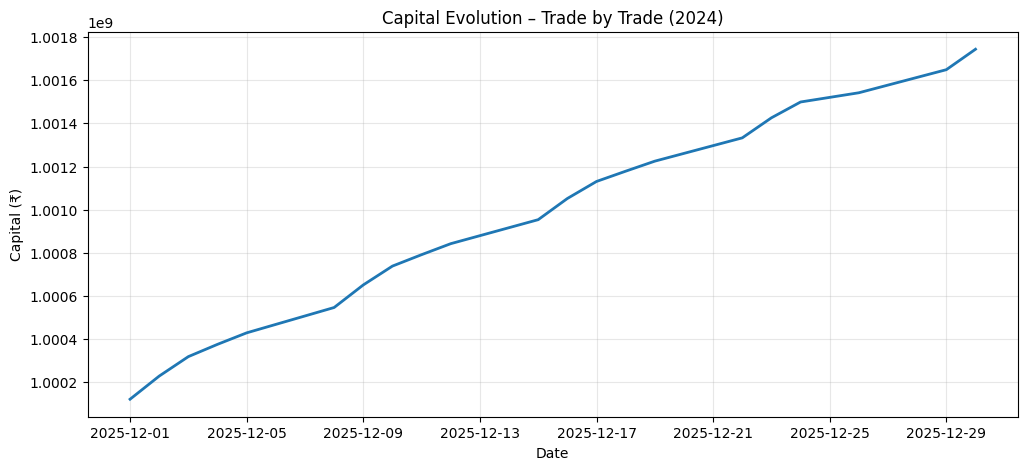

In [4]:
# ============================================================
# NIFTY OPTIONS TRADING SYSTEM (DAILY – NSE READY)
# CAPITAL EVOLUTION PER TRADE | FULL YEAR 2024
# ============================================================

# ------------------ LIBRARIES ------------------
!pip install yfinance scipy ta -q

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from ta.momentum import RSIIndicator
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1. DATA DOWNLOAD
# ============================================================

start = "2025-12-01"
end   = "2025-12-31"

nifty = yf.download("^NSEI", start=start, end=end)
vix   = yf.download("^INDIAVIX", start=start, end=end)

data = pd.concat([nifty['Close'], vix['Close']], axis=1)
data.columns = ['NIFTY', 'INDIA_VIX']
data.dropna(inplace=True)

# ============================================================
# 2. VOLATILITY REGIME IDENTIFICATION
# ============================================================

data['VIX_Change'] = data['INDIA_VIX'].diff()
data['VIX_RSI'] = RSIIndicator(data['INDIA_VIX'], window=14).rsi()

def classify_vix_regime(vix, change):
    if vix < 15:
        return "LOW_VOL"
    elif 15 <= vix <= 20 and change > 0:
        return "RISING_VOL"
    elif vix > 20:
        return "HIGH_VOL"
    else:
        return "NEUTRAL"

data['Vol_Regime'] = data.apply(
    lambda x: classify_vix_regime(x['INDIA_VIX'], x['VIX_Change']),
    axis=1
)

# ============================================================
# 3. STRATEGY SELECTION
# ============================================================

def select_strategy(regime):
    if regime == "LOW_VOL":
        return "SHORT_STRANGLE"
    elif regime == "RISING_VOL":
        return "LONG_STRADDLE"
    else:
        return "NO_TRADE"

data['Strategy'] = data['Vol_Regime'].apply(select_strategy)

# ============================================================
# 4. BLACK–SCHOLES OPTION PRICING
# ============================================================

def bs_price(S, K, T, r, sigma, opt):
    if T <= 0:
        return max(S-K,0) if opt=="CALL" else max(K-S,0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if opt=="CALL":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ============================================================
# 5. STRIKES & WEEKLY EXPIRY
# ============================================================

def select_strikes(spot):
    atm = round(spot/50)*50
    return atm, atm+100, atm-100, atm+300, atm-300

def days_to_expiry(date):
    return max(4 - date.weekday(), 0)

data['Days_To_Expiry'] = data.index.map(days_to_expiry)
data['T'] = data['Days_To_Expiry'] / 252

# ============================================================
# 6. STRATEGY EXECUTION + TRADE LOG
# ============================================================

RISK_FREE = 0.06
TCOST = 0.0015

trade_log = []

for i in range(len(data)):
    row = data.iloc[i]
    date = data.index[i]

    S = row['NIFTY']
    sigma = row['INDIA_VIX'] / 100
    T = max(row['T'], 1/252)

    atm, call, put, hcall, hput = select_strikes(S)

    premium = 0
    hedge = 0
    pnl = 0

    if row['Strategy'] == "SHORT_STRANGLE":
        premium = (
            bs_price(S, call, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, put,  T, RISK_FREE, sigma, "PUT")
        )
        hedge = (
            bs_price(S, hcall, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, hput,  T, RISK_FREE, sigma, "PUT")
        )
        pnl = premium - hedge

    elif row['Strategy'] == "LONG_STRADDLE":
        premium = (
            bs_price(S, atm, T, RISK_FREE, sigma, "CALL") +
            bs_price(S, atm, T, RISK_FREE, sigma, "PUT")
        )
        pnl = -premium

    pnl = pnl * (1 - TCOST)

    trade_log.append({
        "Date": date,
        "Strategy": row['Strategy'],
        "Vol_Regime": row['Vol_Regime'],
        "Net_PnL_per_Lot": pnl
    })

trades = pd.DataFrame(trade_log)

# ============================================================
# 7. POSITION SIZING
# ============================================================

INITIAL_CAPITAL = 10_000_00000   # ₹1 crore
RISK_PCT = 0.01
MAX_LOSS_PER_LOT = 10_000

lots = max(1, int((INITIAL_CAPITAL * RISK_PCT) // MAX_LOSS_PER_LOT))

# ============================================================
# 8. CAPITAL EVOLUTION (KEY SECTION)
# ============================================================

capital = INITIAL_CAPITAL

trades['Capital_Before'] = 0.0
trades['Trade_Impact'] = 0.0
trades['Capital_After'] = 0.0
trades['Capital_Impact_%'] = 0.0

for i in range(len(trades)):
    trades.loc[i, 'Capital_Before'] = capital

    trade_pnl = trades.loc[i, 'Net_PnL_per_Lot'] * lots
    trades.loc[i, 'Trade_Impact'] = trade_pnl

    capital = capital + trade_pnl
    trades.loc[i, 'Capital_After'] = capital

    trades.loc[i, 'Capital_Impact_%'] = trade_pnl / trades.loc[i, 'Capital_Before']

# ============================================================
# 9. PERFORMANCE METRICS
# ============================================================

trades['Portfolio_Return'] = trades['Capital_Impact_%']
equity = trades['Capital_After']

max_dd = (equity / equity.cummax() - 1).min()
sharpe = trades['Portfolio_Return'].mean() / trades['Portfolio_Return'].std() * np.sqrt(252)

def historical_var(returns, conf=0.95):
    return np.percentile(returns, (1-conf)*100)

def expected_shortfall(returns, conf=0.95):
    var = historical_var(returns, conf)
    return returns[returns <= var].mean()

VaR_95 = historical_var(trades['Portfolio_Return'], 0.95)
ES_95  = expected_shortfall(trades['Portfolio_Return'], 0.95)

print("\n========= FINAL PERFORMANCE SUMMARY =========")
print("Total Return :", round(equity.iloc[-1]/INITIAL_CAPITAL - 1, 4))
print("Sharpe Ratio :", round(sharpe, 2))
print("Max Drawdown :", round(max_dd, 4))
print("VaR (95%)    :", round(VaR_95, 4))
print("ES (95%)     :", round(ES_95, 4))
print("Lots Traded  :", lots)

# ============================================================
# 10. CAPITAL EVOLUTION PLOT
# ============================================================

plt.figure(figsize=(12,5))
plt.plot(trades['Date'], trades['Capital_After'], linewidth=2)
plt.title("Capital Evolution – Trade by Trade (2024)")
plt.xlabel("Date")
plt.ylabel("Capital (₹)")
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 11. EXPORT TRADE-BY-TRADE CAPITAL TABLE
# ============================================================

trades.to_excel("Trade_by_Trade_Capital_Evolution_2024.xlsx", index=False)
